# Preprocessing

## Featurizing

In [7]:
import mdtraj as md
import numpy as np
import datetime
import tensorflow as tf
import nglview as nv


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

from utils import split_dataset
from ae import asmsa_ae, compile_asmsa_ae



In [8]:
tr = "trpcage_ds_nH.xtc"
conf = "trpcage_npt400_nH.pdb"

traj = md.load_xtc(tr, top=conf)
backbone_atoms = traj.topology.select('backbone')
traj.superpose(traj, 0, atom_indices=backbone_atoms)


<mdtraj.Trajectory with 50001 frames, 144 atoms, 20 residues, and unitcells at 0x734d9be29de0>

In [9]:
view = nv.show_mdtraj(traj)

view.add_representation('line', selection='protein')
view

NGLWidget(max_frame=50000)

In [10]:
n_frames, n_atoms = traj.n_frames, traj.n_atoms #50001, 144

In [11]:
p_indices = traj.topology.select("protein")
n_p = len(p_indices)

bb_indices = traj.topology.select("backbone")
n_bb = len(bb_indices)

ca_indices = traj.topology.select("name CA")
pairs = np.array([(i, j) for idx,i in enumerate(ca_indices) 
                          for j in ca_indices[idx+1:]])

coords_bb = traj.xyz[:,bb_indices,:]
#coords = traj.xyz.reshape(n_frames, n_atoms * 3) #from (n_frame, n_atoms, 3) to (n_frame, n_atoms*3) 
coords = coords_bb.reshape(n_frames, -1)

dists = md.compute_distances(traj, pairs) 

bonds = list(traj.topology.bonds)
bond_pairs = [[b.atom1.index, b.atom2.index] for b in bonds]
bond_lengths = md.compute_distances(traj, bond_pairs)


phi_angles = md.compute_phi(traj)[1]
psi_angles = md.compute_psi(traj)[1]
phi_sin = np.sin(phi_angles)
phi_cos = np.cos(phi_angles)  
psi_sin = np.sin(psi_angles)
psi_cos = np.cos(psi_angles)

# Side chain dihedrals with sin/cos
chi1_angles = md.compute_chi1(traj)[1]
chi2_angles = md.compute_chi2(traj)[1]
chi1_sin = np.sin(chi1_angles)
chi1_cos = np.cos(chi1_angles)
chi2_sin = np.sin(chi2_angles) 
chi2_cos = np.cos(chi2_angles)


In [12]:
feat = np.concatenate([coords,phi_sin,phi_cos,psi_sin,psi_cos,chi1_sin,chi1_cos,chi2_sin,chi2_cos], axis=1)

In [13]:
scaler = StandardScaler()
features_normalized = scaler.fit_transform(feat)
features_normalized.shape

(50001, 366)

## NN preprocessing

In [14]:
# Uso:
ds_train, ds_val, ds_test, ds_all = split_dataset(features_normalized, train_size=70, val_size=15, batch_size=64, seed=42)

# Opzionale: Data Augmentation per autoencoder
def add_data_augmentation(ds_train, noise_factor=0.1):
    """
    Aggiunge rumore ai dati di input mantenendo il target pulito
    """
    def add_noise(x, y):
        noise = tf.random.normal(tf.shape(x), stddev=noise_factor)
        x_noisy = x + noise
        x_noisy = tf.clip_by_value(x_noisy, 0.0, 1.0)  # Assumendo dati normalizzati [0,1]
        return x_noisy, y  # Input rumoroso, target pulito
    
    return ds_train.map(add_noise, num_parallel_calls=tf.data.AUTOTUNE)

# Per usare data augmentation:
# ds_train = add_data_augmentation(ds_train, noise_factor=0.05)

Dataset Statistics:
  Train: 35000 samples, 546 batches
  Val:   7500 samples, 118 batches
  Test:  7501 samples, 118 batches
  Batch size: 64


# AE

In [9]:
'''

Batch Norm, nel caso, va prima della layer activation)
'''

'\n\nBatch Norm, nel caso, va prima della layer activation)\n'

In [10]:
latent_dim = 2

autoencoder, encoder, decoder = asmsa_ae(
    n_features=feat.shape[1],
    latent_dim=latent_dim)


autoencoder = compile_asmsa_ae(autoencoder)


autoencoder.summary()


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ enc_input (InputLayer)          │ (None, 366)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2)              │        58,274 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 366)            │        23,694 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,968 (320.19 KB)

 Trainable params: 81,072 (316.69 KB)

 Non-trainable params: 896 (3.50 KB)

In [11]:
log_dir = "logs/autoencoder/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


callbacks = [
    tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,        # salva istogrammi dei pesi ogni epoca
    write_graph=True,        # salva anche il grafo del modello
    update_freq='epoch',     # ogni epoca
    ),

    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,  # più pazienza con lr scheduling
        min_delta=1e-5,  # soglia più stretta
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),

    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    ),

    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'best_autoencoder_{latent_dim}d.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )
    
]

tensorboard --logdir logs/autoencoder --host localhost --port 6006

In [12]:
autoencoder.fit(ds_train,epochs=500,validation_data=ds_val,callbacks=callbacks)

Epoch 1/500


I0000 00:00:1753967482.854046  367556 service.cc:146] XLA service 0x70871c002ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753967482.854094  367556 service.cc:154]   StreamExecutor device (0): NVIDIA A100 80GB PCIe MIG 1g.10gb, Compute Capability 8.0
2025-07-31 13:11:22.981155: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-31 13:11:23.323849: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 25/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0890     

I0000 00:00:1753967505.211374  367556 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


544/546 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0141
Epoch 1: val_loss improved from inf to 0.85332, saving model to best_autoencoder_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 1.0138 - val_loss: 0.8533 - learning_rate: 1.0000e-04
Epoch 2/500
544/546 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8416
Epoch 2: val_loss improved from 0.85332 to 0.76140, saving model to best_autoencoder_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.8414 - val_loss: 0.7614 - learning_rate: 1.0000e-04
Epoch 3/500
534/546 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7736
Epoch 3: val_loss improved from 0.76140 to 0.73836, saving model to best_autoencoder_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.7735 - val_loss: 0.7384 - learning_rate: 1.0000e-04
Epoch 4/500
540/546 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7619
Epoch 4: val_loss improved from 0.73836 to 0.72976, saving model to best_autoencoder_2d.keras
546/546 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.7618 - 

In [3]:
from tensorflow.keras.models import load_model
import numpy as np
autoencoder = load_model(f'best_autoencoder_{latent_dim}d.keras')
encoder = autoencoder.get_layer("encoder")
decoder = autoencoder.get_layer("decoder")

encoder.save(f"best_encoder_{latent_dim}d.keras")
decoder.save(f"best_decoder_{latent_dim}d.keras")


2025-07-31 13:20:07.465586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-31 13:20:07.481924: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-31 13:20:07.486894: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-31 13:20:07.502522: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-31 13:20:08.408175: W tensorflow/compiler/tf2

NameError: name 'latent_dim' is not defined

In [14]:
from vae import *

In [ ]:
# Example usage:
n_features = feat.shape[1]
vae, enc, dec = build_asmssa_vae(n_features, latent_dim=2)
vae.compile(optimizer=tf.keras.optimizers.AdamW())
vae.fit(ds_train, epochs=500, validation_data=ds_val, callbacks=callbacks)

Epoch 1/500


# Decode and visualize

In [15]:
autoencoder = load_model(f'best_autoencoder_2d.keras')
encoder = autoencoder.get_layer("encoder")
decoder = autoencoder.get_layer("decoder")

In [18]:
import matplotlib.pyplot as plt
def plot_latent_space(latent_dim, encoder, dataset, conf, target, cmap='rainbow', figsize=(8,8)):
    """
    Computes latent embeddings and plots them in 2D.

    Args:
        encoder: the encoder model returning [z_mean, z_log_var, z]
        dataset: input data or tf.data.Dataset yielding inputs (and optionally labels)
        labels: optional array-like of same length as dataset for coloring
        cmap: matplotlib colormap
        figsize: tuple for figure size
    """
    # Get embeddings
    results = encoder.predict(dataset)
    # results = [z_mean, z_log_var, z]
    emb = np.array(results)  # results[2] use sampled z; shape (N,2)

    rms_ref = md.load_pdb(conf)
    rms_ref_bb   = rms_ref.atom_slice(bb_indices)
    rms_tr = md.load_xtc(tr, top=rms_ref)
    rmsd = md.rmsd(rms_tr, rms_ref)

    #z = np.random.normal(loc=0.0, scale=1.0, size=(latent_dim,))

    dists = np.linalg.norm(emb - target, axis=1)
    # 4a. Se vuoi, ad esempio, le K righe più vicine:
    K = 1
    idx_closest = np.argsort(dists)[:K]
    sample = emb[idx_closest].reshape(1, latent_dim)
    
    plt.figure(figsize=figsize)

    plt.scatter(emb[:,0], emb[:,1], c=rmsd,s=0.5, cmap=cmap)
    plt.scatter(sample[:,0], sample[:,1], marker="X", c="Black")

    plt.show()
    return emb, sample

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


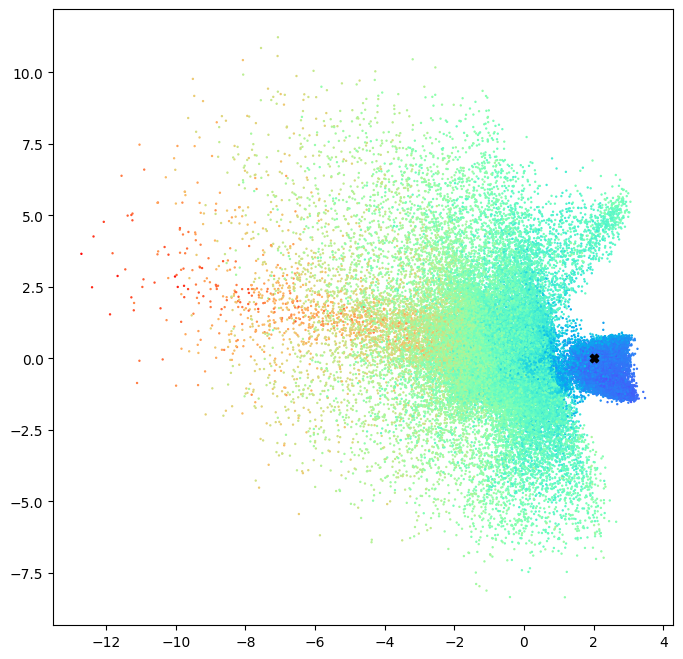

In [30]:
latent_dim = 2
target = np.array([2,0]).reshape(1, 2)
emb, sample = plot_latent_space(latent_dim, encoder, ds_all, conf, target)

In [31]:
emb.shape

(50001, 2)

In [32]:
s = decoder.predict(sample)
s_orig = scaler.inverse_transform(s)

coords_flat = s_orig[0, :coords.shape[1]]                    
coords_recons = coords_flat.reshape((n_bb, 3))

new_traj = md.Trajectory(
    xyz=np.array([coords_recons]),     
    topology=rms_ref_bb.topology     
)


new_traj.save_pdb("reconstructed.pdb")

import nglview as nv

view = nv.show_file('reconstructed.pdb')
view.clear_representations()
view.add_line() 
#view.add_cartoon()
view.center()
view

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


NGLWidget()